Filippo Cucchetto 2110510

Federico Simioni 2097001

Gabriel Amorosetti 2107530

Emanuele Quaglio 2106975

In [145]:
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
# AdaBoost Algorithm
from sklearn.ensemble import AdaBoostClassifier
# Gradient Boosting 
from sklearn.ensemble import GradientBoostingClassifier
# XGBoost 
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance, to_graphviz, plot_tree
print("XGBoost version:",xgboost.__version__)

mycmap = "winter"
mpl.rcParams['image.cmap'] = mycmap
plt.rcParams['font.size'] = 13

XGBoost version: 2.0.3


In [146]:
np.random.seed(12345)

dname="./DATA/"
str0="_XGB_24.dat"
fnamex=dname+'x'+str0
fnamey=dname+'y'+str0
x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
y = np.loadtxt(fnamey)
y = y.astype(int)
N,L = len(x), len(x[0])

N_train = int(0.75*N)
x_train,y_train = x[:N_train],y[:N_train]
x_test,y_test = x[N_train:],y[N_train:]
print(f"N={N}, N_train={N_train}, L={L}")

N=4000, N_train=3000, L=4


[-31.608 -29.544   6.773   9.554] 0
[46.451 15.318 24.891 15.357] 1
[ 24.771  46.131 -49.161 -39.356] 1
[-20.13   15.641  30.981  37.218] 1
[46.465 22.369 14.248 21.745] 1


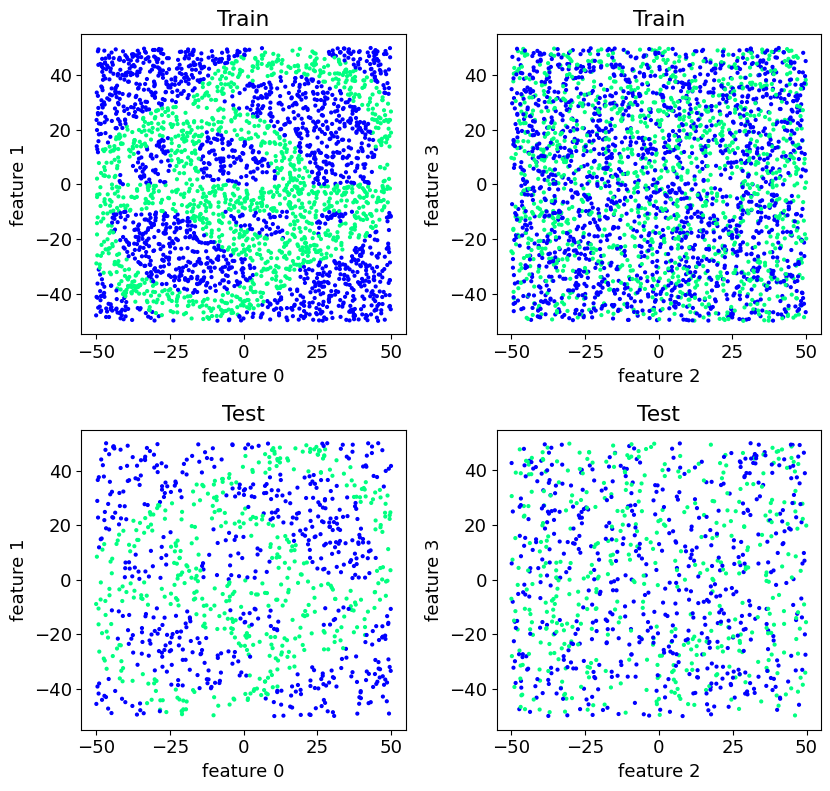

In [27]:
def scat(ax,x,y,i=0,j=1,s=4,title=""):
    ax.scatter(x[:,i],x[:,j],s=s,c=y)
    ax.set_xlabel(f"feature {i}")
    ax.set_ylabel(f"feature {j}")
    ax.set_title(title)

for n in range(5):
    print(x[n],y[n])

fig,AX = plt.subplots(2,2,figsize=(8.5,8.1))
scat(AX[0,0],x_train,y_train,title="Train")
scat(AX[0,1],x_train,y_train,i=2,j=3,title="Train")
scat(AX[1,0],x_test,y_test,title="Test")
scat(AX[1,1],x_test,y_test,i=2,j=3,title="Test")
fig.tight_layout()
plt.show()

In [118]:
def classify(clf=GradientBoostingClassifier(),show=False, show_prediction_plot=True):
    # GradientBoostingClassifier():
    #   n_estimators = 100 (default)
    #   loss function = deviance(default) used in Logistic Regression
    # XGBClassifier()
    #   n_estimators = 100 (default)
    #   max_depth = 3 (default?)
    clf.fit(x_train,y_train)
    y_hat = clf.predict(x_test)
    
    print("errors: {:.2f}%   Accuracy={:.3f}".format(100*(1-clf.score(x_test, y_test)),clf.score(x_test, y_test)))
    S=50
    dx = 1
    x_seq=np.arange(-S,S+dx,dx)
    nx = len(x_seq)
    x_plot=np.zeros((nx*nx,L))
    q=0
    for i in range(nx):
        for j in range(nx):
            x_plot[q,:2] = [x_seq[i],x_seq[j]]
            q+=1
    y_plot= clf.predict(x_plot)
    print(np.unique(y_plot, return_counts=True))
    print(np.unique(y_train, return_counts=True))

    if show_prediction_plot:
        fig,AX = plt.subplots(1,2,figsize=(8.2,4))
        scat(AX[0],x_plot[:],y_plot,s=dx,title="predicted")
        #scat(AX[0],x_test[:],y_hat,s=dx,title="predicted")
        scat(AX[1],x_train[:],y_train,title="training set")
        fig.tight_layout()
        plt.show()
    
    if show:      
        dump_list = clf.get_booster().get_dump()
        num_trees = len(dump_list)
        print("num_trees=",num_trees)
        
        fig, AX = plt.subplots(2,1,figsize=(12, 5))
        for i in range(min(2,num_trees)):
            ax=AX[i]
            plot_tree(clf, num_trees=i, ax=ax)
        fig.savefig("DATA/tree-classif.png", dpi=400, pad_inches=0.02)   
        plt.show()
    return clf.score(x_test, y_test)

### Classify
If the “objective” hyperparameter is left unspecified, XGBClassifier looks at the data and chooses automatically the loss functions and the evaluation metrics (--> WARNING)

## XGBoost
https://xgboost.readthedocs.io/en/stable/python/python_api.html

errors: 5.20%   Accuracy=0.948
(array([0, 1]), array([5417, 4784]))
(array([0, 1]), array([1675, 1325]))


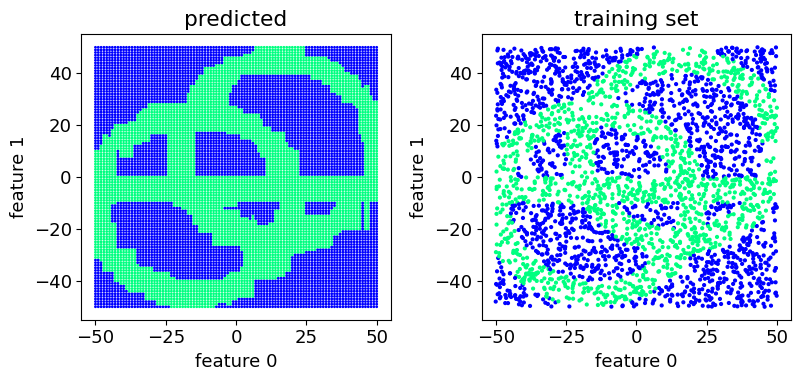

num_trees= 100


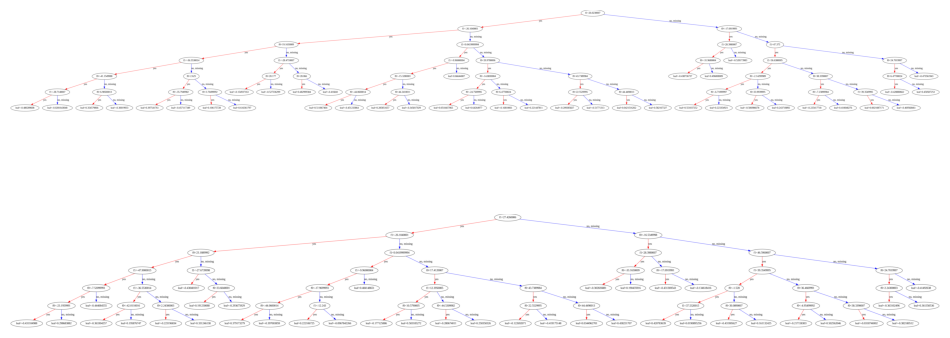

0.948

In [163]:
xgb_model = XGBClassifier(seed=1,
                      objective='binary:logistic') 
       # importance_type="gain" #weight, cover, ...
       # learning_rate=0.4,
       # reg_lambda=0.001, 
       # n_estimators=30)

classify(xgb_model, show=True)

None
[0.4891835  0.37623835 0.06590363 0.06867457]


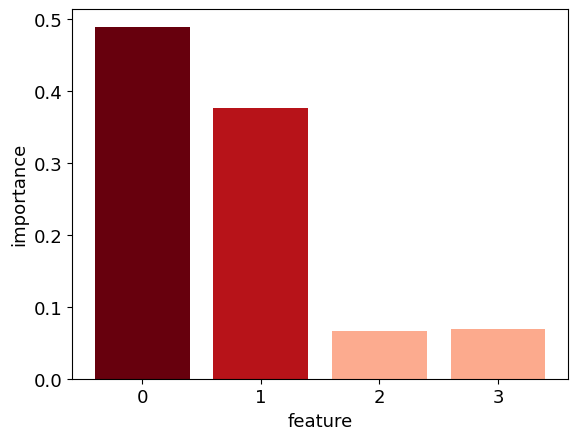

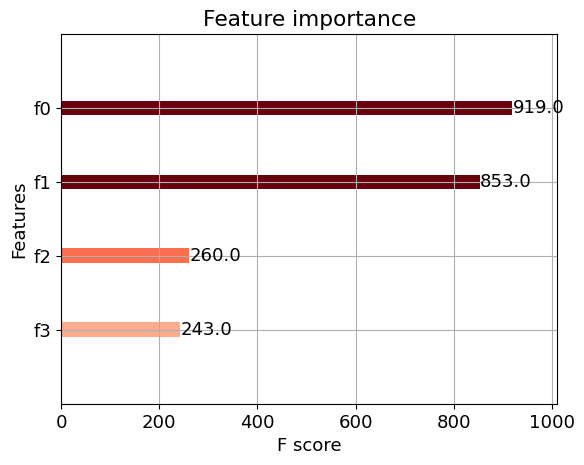

In [164]:
# https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/
# feature importance

def plot_feature_importance_analysis(model):
        print(model.importance_type)
        print(model.feature_importances_)
        # plot
        my_cmap = plt.get_cmap("Reds")
        rescale = lambda y: 0.3 + 0.7 * (y - np.min(y)) / (np.max(y) - np.min(y))
        plt.bar(range(len(model.feature_importances_)), model.feature_importances_,
                color=my_cmap(rescale(model.feature_importances_)))
        plt.xlabel("feature")
        plt.ylabel("importance")
        plt.xticks(np.arange(L))
        plt.yticks(np.arange(L))
        plt.title(model.importance_type)
        plt.show()

        rescale_r = lambda y: 0.3 + 0.7 * (np.max(y) - y) / (np.max(y) - np.min(y))
        plot_importance(model,color=my_cmap(rescale_r(model.feature_importances_)))
        plt.show()

plot_feature_importance_analysis(xgb_model)

Documentation: https://xgboost.readthedocs.io/en/stable/python/python_api.html

    ‘weight’: the number of times a feature is used to split the data across all trees.

    ‘gain’: the average gain across all splits the feature is used in.

    ‘cover’: the average coverage across all splits the feature is used in.

    ‘total_gain’: the total gain across all splits the feature is used in.

    ‘total_cover’: the total coverage across all splits the feature is used in.


0 weight [919. 853. 260. 243.]
1 gain [4.56883669 3.5139606  0.61552137 0.64140123]
2 total_gain [4198.76074219 2997.40844727  160.03555298  155.86050415]
3 cover [49.8643837  66.05692291 54.26316071 54.39147949]
4 total_cover [45825.3671875  56346.5546875  14108.421875   13217.12988281]


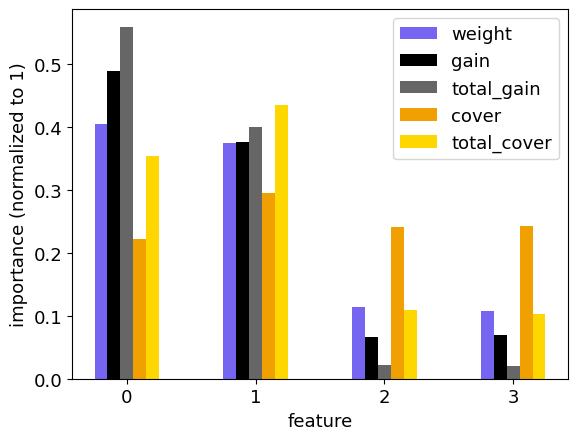

In [31]:
def plot_importance_type_analysis(model):

    # if the importance type is “total_gain”, then the score is sum of loss change for each split from all trees.
    list_type=["weight","gain","total_gain","cover","total_cover"]
    list_col=["#7565F0","k","#666666","#F0A000","gold"]

    for i,t in enumerate(list_type):
        feature_imp = model.get_booster().get_score(importance_type=t)
        keys = list(feature_imp.keys())
        values = np.array(list(feature_imp.values()))
        print(i,t,values)
        values= values/np.sum(values)
        plt.bar(np.arange(L)+(i-L/2)/10, values,color=list_col[i],width=0.1,label=t)
    plt.xlabel("feature")
    plt.ylabel("importance (normalized to 1)")
    plt.xticks(np.arange(L))
    plt.legend()
    plt.show()

plot_importance_type_analysis(xgb_model)

## Normal Gradient Boosting

errors: 19.50%   Accuracy=0.805


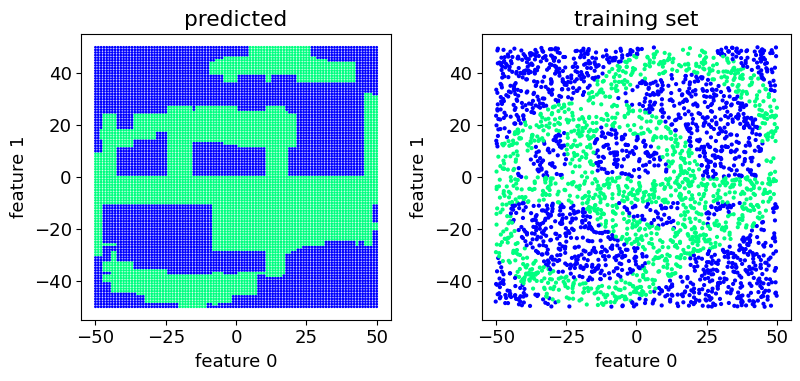

0.805

In [32]:
# GradientBoostingClassifier()
classify()

## AdaBoost

/usr/local/lib64/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


errors: 34.10%   Accuracy=0.659


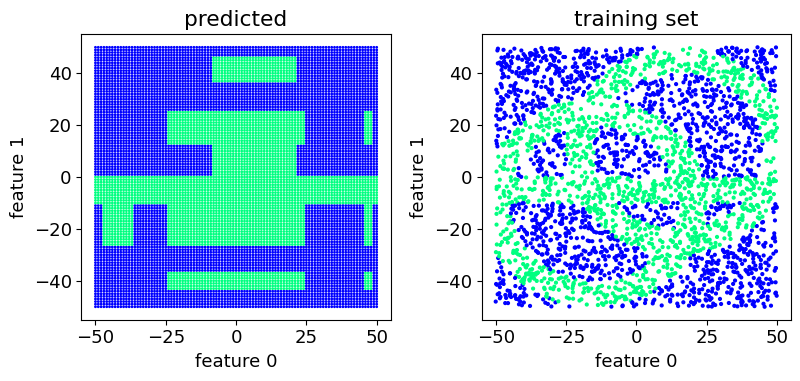

In [167]:
classify(clf=AdaBoostClassifier())

# 1. Model complexity, parameters and regularization

First we explore the parameters space logarithmically, to span many orders of magnitude efficiently. We use GridSearchCV from sklearn library.
(The code below is very slow to run. Commented as a precaution)

In [ ]:
'''
parameters0 = {
      'importance_type' : ['gain', 'weight', 'cover', 'total_gain', 'total_cover'],
      'learning_rate' : list(map(lambda x: 10**x, range(-5, 1, 1))),
      'reg_lambda' : list(map(lambda x: 10**x, range(-5, 1, 1))), 
      'n_estimators' : range(50,300, 50)
            }
clf = GridSearchCV(model, parameters0, cv=4)
GSCV=clf.fit(x, y)
'''


"\nparameters0 = {'importance_type' : ['gain', 'weight', 'cover', 'total_gain', 'total_cover'],\n       'learning_rate' : list(map(lambda x: 10**x, range(-5, 1, 1))),\n       'reg_lambda' : list(map(lambda x: 10**x, range(-5, 1, 1))), \n       'n_estimators' : range(50,300, 50)\n             }\nclf = GridSearchCV(model, parameters0, cv=4)\nGSCV=clf.fit(x, y)\n"

Then we focus on the most promising ranges exploring them linearly.

In [110]:
parameters1 = {'importance_type' : ['gain', 'weight', 'cover', 'total_gain', 'total_cover'],
      'learning_rate' : list(np.linspace(0, 1, 10)),
      'reg_lambda' : list(np.linspace(0, 1, 10)),
      'n_estimators' : range(50,300, 50),
      'max_depth' : range(2, 11, 2)
            }
model=xgb_model
clf = GridSearchCV(model, parameters1, cv=4)
GSCV=clf.fit(x, y)

KeyboardInterrupt: 

In order to look for the simplest yet effective and accurate model, we select the subset of the parameters combinations, evaluated above, that produced an accuracy higher than a threshold we deem sufficiently good. Then, we look for the combinations that minimize the complexity, defined in a proper way. 

Indeed, we define a `complexity_estimate` function that takes as arguments the max depth of the trees, the number of estimators and the *l2*-norm of the model parameters. 

We follow the form of the $\Omega$-regularization defined in Mehta (sum over estimators of number of leaves plus *l2*-norm): 
* summing over trees corresponds to multiply by n_estimators in first approximation (we assume tree 'complexity' to be homogeneous);
* we assumed the number of leavs to be roughly ~$2^{max\_depth}$, but after some trials we find out that approximating the dependency as linear (with a weight `u`) leads to a more stable complexity estimation w.r.t. the `max_depth` parameter;
* finally we assume that the bigger the `reg_lambda` parameter is, the smaller the *l2*-norm will be kept by the learning algorithm. Thus we add to the complexity a term inversely proportional to `reg_lambda`, weighted by a `v` parameter.

We tune `u` and `v` manually.

The goal is to quantify *a priori* (i.e., before training) the complexity of the model as well as possible.

In order to incentivize small increase in complexity as far as they would bring to big accuracxy improvement, we also multiply the complexity function described above by a $1-accuracy$ factor.

In [382]:
import pandas as pd
from itertools import product as CartProd
print('best parameters combination of global grid search, with score associated:\n ', GSCV.best_params_,GSCV.best_score_ )
#print(clf.param_grid)
param_combs=list(CartProd(*clf.param_grid.values()))
df=pd.DataFrame(param_combs, columns=['importance_type', 'learning_rate', 'reg_lambda', 'n_estimators', 'max_depth'])
#print(df)
df['mean_accuracy']=GSCV.cv_results_['mean_test_score']
good_accuracy=0.9
df_good=df[df['mean_accuracy']>good_accuracy]
def complexity_estimate(n_estimators, reg_lambda, max_depth, accuracy): 
    u,v=0.021,1
    return n_estimators*(u*max_depth+v/reg_lambda)*(1-accuracy)
df_good['complexity']=complexity_estimate(df_good['n_estimators'], df_good['reg_lambda'], df_good['max_depth'], df_good['mean_accuracy'])
# Finding the row with the minimum value in column 'A'
min_row_index = df_good['complexity'].idxmin()
# Retrieving the row corresponding to the minimum value in column 'A'
min_row = df_good.loc[min_row_index]
print('LESS COMPLEX YET SUFFICIENTLY GOOD MODEL:\n', min_row)

best parameters combination of global grid search, with score associated:
  {'importance_type': 'gain', 'learning_rate': 0.1111111111111111, 'max_depth': 10, 'n_estimators': 200, 'reg_lambda': 0.0} 0.94825
LESS COMPLEX YET SUFFICIENTLY GOOD MODEL:
 importance_type        gain
learning_rate      0.222222
reg_lambda              1.0
n_estimators             50
max_depth                 4
mean_accuracy         0.945
complexity            2.981
Name: 726, dtype: object


/tmp/ipykernel_58109/1973740472.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_good['complexity']=complexity_estimate(df_good['n_estimators'], df_good['reg_lambda'], df_good['max_depth'], df_good['mean_accuracy'])


The resulting model scores a sufficiently high accuracy on the cross-validation, and the number of estimators and the depth are reasonably low. The l2 regularization term is 1, contributing to keep the model simple.

In [111]:
simple_good_params= {'importance_type':        'gain',
                        'learning_rate':      0.222222,
                        'reg_lambda':              1.0,
                        'n_estimators':             50,
                        'max_depth':                  4
                    }

errors: 9.80%   Accuracy=0.902
(array([0, 1]), array([5421, 4780]))
(array([0, 1]), array([1675, 1325]))


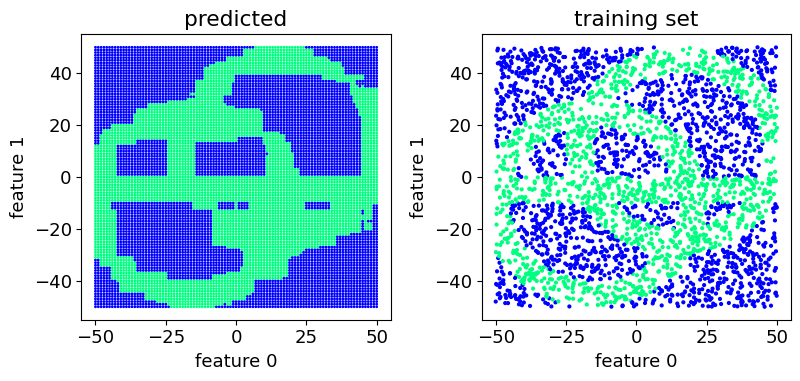

num_trees= 50


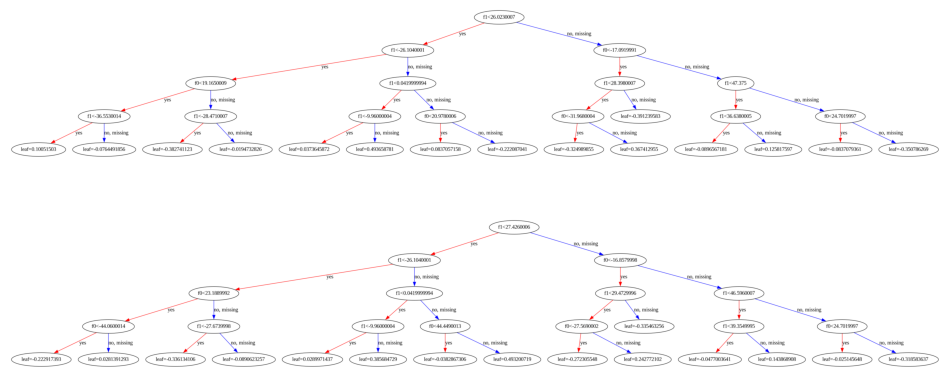

0.902

In [122]:
#simple_good_params=dict(min_row)
simple_good_params['seed']=1
simple_good_params['objective']='binary:logistic'
simple_good_model=XGBClassifier(**simple_good_params)
classify(simple_good_model, show=True)

The plots of the results are satisfying.

gain
[0.44620588 0.55379415]


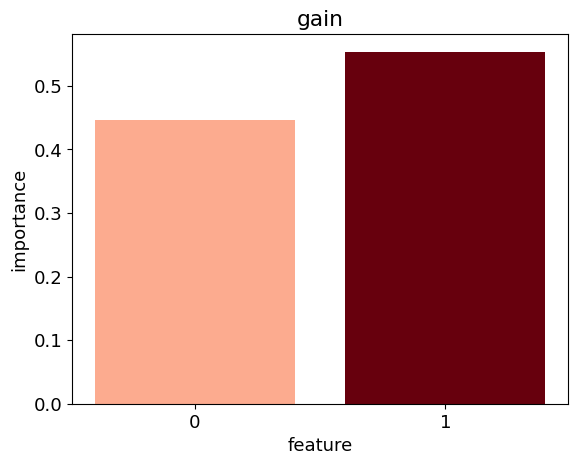

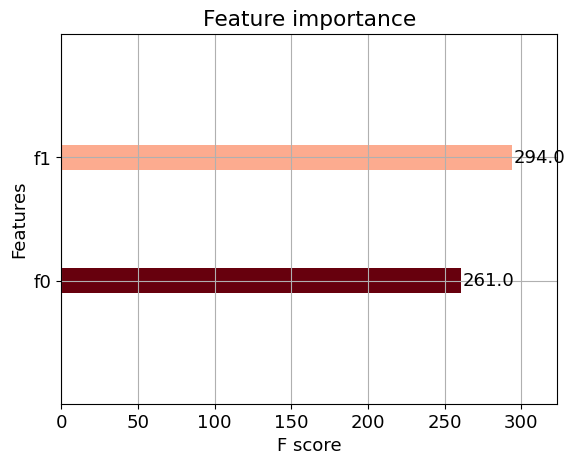

In [114]:
plot_feature_importance_analysis(simple_good_model)

0 weight [54. 87.  5.  4.]
1 gain [18.81690216 40.85776901  4.86018372  5.9807744 ]
2 total_gain [1016.1126709  3554.62597656   24.30091858   23.92309761]
3 cover [410.87713623 467.68978882 361.61026001 531.26959229]
4 total_cover [22187.36523438 40689.01171875  1808.05126953  2125.07836914]


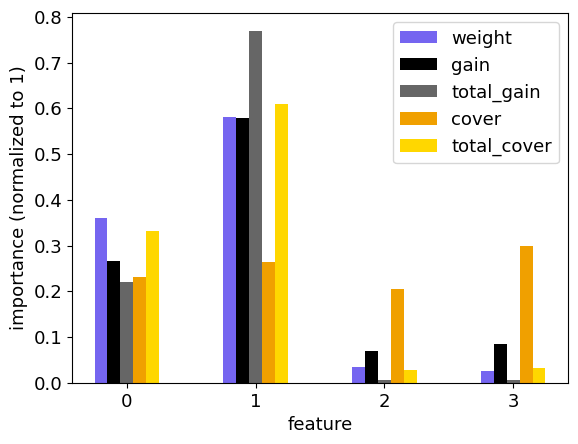

In [192]:
plot_importance_type_analysis(simple_good_model)

Let's compare execution time of the simpified and the defaukt version of the XGBoost models:

In [ ]:
print('........................................xgb_model timing.....................................')
%timeit classify(xgb_model, show_prediction_plot=False)
print('................................simple_good_model timing.....................................')
%timeit classify(simple_good_model, show_prediction_plot=False)

The results are respectively 62.9 secs and 39.9 secs.

In [346]:
print(39.9/62.9*100)

63.43402225755167


The `simple_good_model` proves faster, as expected, taking 63.4% the time `xgb_model` takes.

# 2. Dimensionality reduction

From the previous feature importance plots we can see that the 0 and 1 features are the relevant ones. We see that the standard PCA is uncapable of distinguish them instead, since the variance of the 2 and 3 coordinates is as much as high, despite them being essentially noise.

In [123]:
from scipy import linalg as la
cov= np.cov(x.T)
l, V= la.eig(cov)
l=np.real_if_close(l)
print(f'components weight (%) from PCA: {l/np.trace(cov)*100}')


components weight (%) from PCA: [26.07473378 24.88232424 24.67585953 24.36708245]


We reduce the data according to the importance analysis, to see how the accuracy of the model changes.

In [124]:
x=x[:, 0:2]

N,L = len(x), len(x[0])

N_train = int(0.75*N)
x_train,y_train = x[:N_train],y[:N_train]
x_test,y_test = x[N_train:],y[N_train:]

errors: 16.30%   Accuracy=0.837


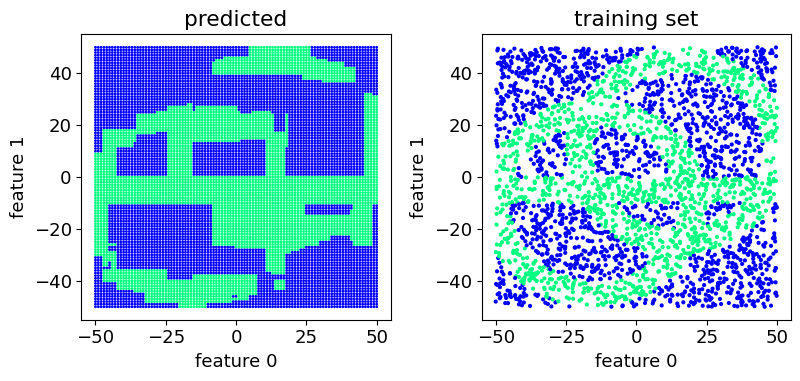

In [195]:
classify()

We observe that the accuracy of the normal Gradient Boosting model improves with dimensionality (feature) reduction.

errors: 4.50%   Accuracy=0.955


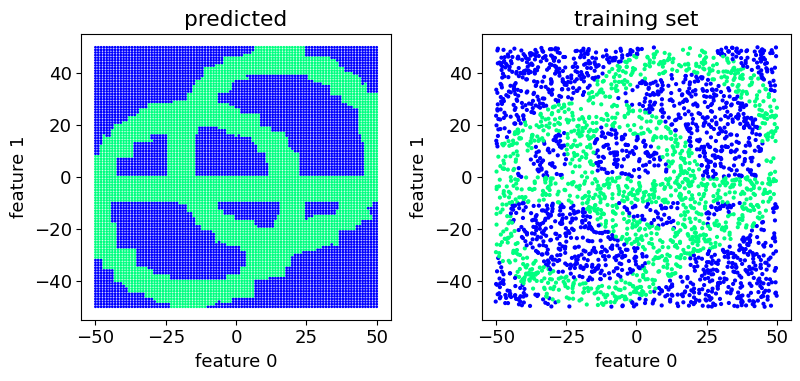

In [196]:
classify(xgb_model)

We observe instead that the accuracy of the XGBoost model slightly improves.

errors: 9.80%   Accuracy=0.902
(array([0, 1]), array([5612, 4589]))
(array([0, 1]), array([1675, 1325]))


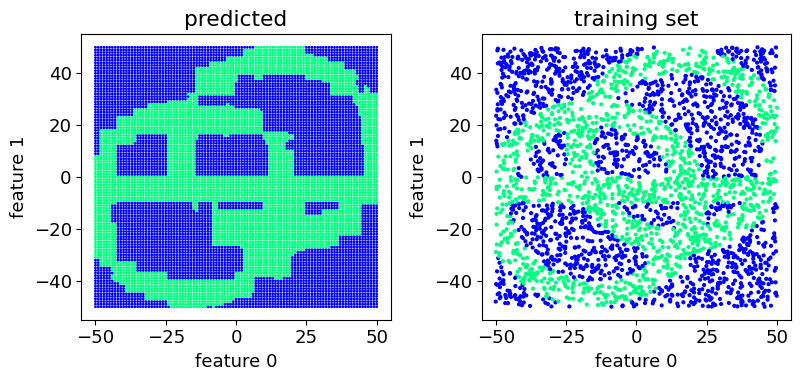

0.902

In [125]:
classify(simple_good_model)

Instead, with our `simple_good_model` the accuracy stays the same.

### Experimental attempt (work in progress) ↓

Below an attempt of dimensionality increase with potentially useful functions of the dataset, according to visual interpretation.

N=4000, N_train=3000, L=5
[ -31.608     -29.544     602.407936  516.7136   3856.6736  ] 0
[  46.451      15.318     412.821124 5056.736525  806.116525] 1
[  24.771      46.131    2614.379161 5155.131602 1714.521602] 1
[ -20.13       15.641     426.050881  657.477781 1723.647781] 1
[  46.465      22.369     749.062161 5465.348386 1002.078386] 1


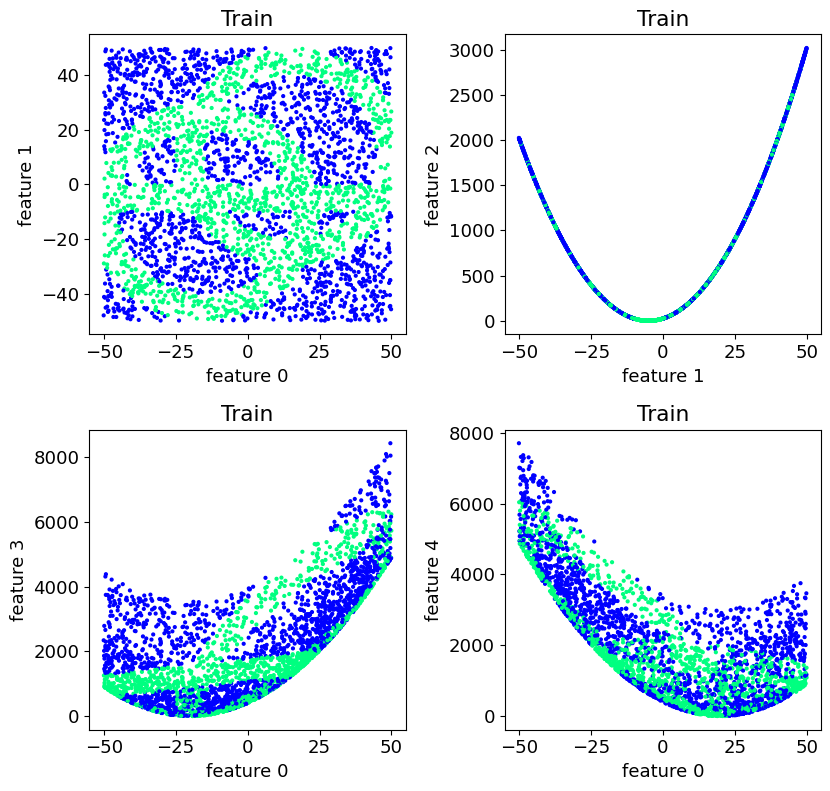

In [132]:
x=np.vstack((x[:,0], x[:,1], (x[:,1]+5)**2, (x[:,0]+20)**2+(x[:,1]+10)**2, (x[:,0]-20)**2+(x[:,1]-5)**2))
x=x.T
N,L = len(x), len(x[0])
N_train = int(0.75*N)
x_train,y_train = x[:N_train],y[:N_train]
x_test,y_test = x[N_train:],y[N_train:]
print(f"N={N}, N_train={N_train}, L={L}")
for n in range(5):
    print(x[n],y[n])

fig,AX = plt.subplots(2,2,figsize=(8.5,8.1))
scat(AX[0,0],x_train,y_train,title="Train")
scat(AX[0,1],x_train,y_train,i=1,j=2,title="Train")
scat(AX[1,0],x_train,y_train,i=0,j=3,title="Train")
scat(AX[1,1],x_train,y_train,i=0,j=4,title="Train")
fig.tight_layout()
plt.show()

In [81]:
def classify_transformed(clf=GradientBoostingClassifier(),show=False, show_prediction_plot=True):
    # GradientBoostingClassifier():
    #   n_estimators = 100 (default)
    #   loss function = deviance(default) used in Logistic Regression
    # XGBClassifier()
    #   n_estimators = 100 (default)
    #   max_depth = 3 (default?)
    clf.fit(x_train,y_train)
    y_hat = clf.predict(x_test)
    
    print("errors: {:.2f}%   Accuracy={:.3f}".format(100*(1-clf.score(x_test, y_test)),clf.score(x_test, y_test)))
    S=50
    dx = 1
    x_seq=np.arange(-S,S+dx,dx)
    nx = len(x_seq)
    x_plot=np.zeros((nx*nx,L))
    q=0
    #print(x_plot)
    for i in range(nx):
        for j in range(nx):
            x_plot[q,:2] = [x_seq[i],x_seq[j]]
            q+=1
    #print(x_plot)
    x_plot=np.vstack((x_plot[:,0], x_plot[:,1], (x_plot[:,1]+5)**2, (x_plot[:,0]+20)**2+(x_plot[:,1]+10)**2, (x_plot[:,0]-20)**2+(x_plot[:,1]-5)**2))
    x_plot=x_plot.T
    y_plot= clf.predict(x_plot)
    print(np.unique(y_plot, return_counts=True))
    print(np.unique(y_train, return_counts=True))

    if show_prediction_plot:
        fig,AX = plt.subplots(1,2,figsize=(8.2,4))
        scat(AX[0],x_plot[:],y_plot,s=dx,title="predicted")
        #scat(AX[0],x_test[:],y_hat,s=dx,title="predicted")
        scat(AX[1],x_train[:],y_train,title="training set")
        fig.tight_layout()
        plt.show()
    
    if show:      
        dump_list = clf.get_booster().get_dump()
        num_trees = len(dump_list)
        print("num_trees=",num_trees)
        
        fig, AX = plt.subplots(2,1,figsize=(12, 5))
        for i in range(min(2,num_trees)):
            ax=AX[i]
            plot_tree(clf, num_trees=i, ax=ax)
        fig.savefig("DATA/tree-classif.png", dpi=400, pad_inches=0.02)   
        plt.show()
    return clf.score(x_test, y_test)

errors: 2.00%   Accuracy=0.980
(array([0, 1]), array([5524, 4677]))
(array([0, 1]), array([1675, 1325]))


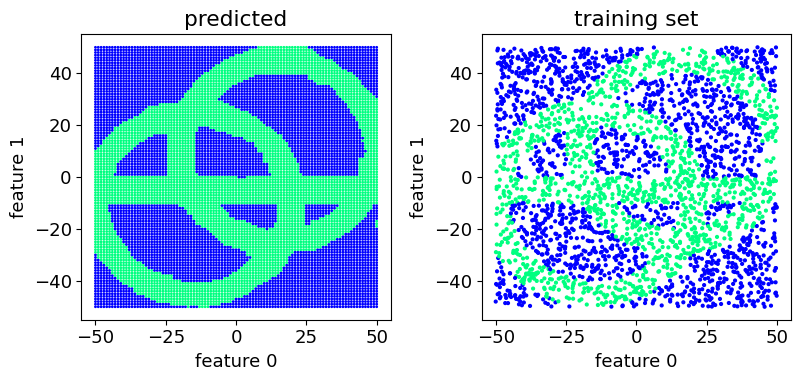

0.98

In [134]:
classify_transformed(xgb_model)

Despite the perplexing plot resulting, we are going to further explore this attempt in the next days for the assignment. 

# 3. XGBoost vs NN

In [54]:
np.random.seed(12345)

dname="./DATA/"
str0="_XGB_24.dat"
fnamex=dname+'x'+str0
fnamey=dname+'y'+str0
x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
y = np.loadtxt(fnamey)
y = y.astype(int)
N,L = len(x), len(x[0])

N_train = int(0.75*N)
x_train,y_train = x[:N_train],y[:N_train]
x_test,y_test = x[N_train:],y[N_train:]
print(f"N={N}, N_train={N_train}, L={L}")

N=4000, N_train=3000, L=4


### We create a neural network model

Here goes definition of a simple nn model without tuning

In [90]:
def classify_nn(nn_model, show_prediction_plot=True):
    # Train the model on the entire training dataset
    nn_model.fit(x_train, y_train)
    
    S=50
    dx = 1
    x_seq=np.arange(-S,S+dx,dx)
    nx = len(x_seq)
    x_plot=np.zeros((nx*nx,L))
    q=0
    for i in range(nx):
        for j in range(nx):
            x_plot[q,:2] = [x_seq[i],x_seq[j]]
            q+=1
    y_plot= nn_model.predict(x_plot)

    if show_prediction_plot:
        fig,AX = plt.subplots(1,2,figsize=(8.2,4))
        scat(AX[0],x_plot[:],y_plot,s=dx,title="predicted")
        scat(AX[1],x_train[:],y_train,title="training set")
        fig.tight_layout()
        plt.show()

    # Evaluate the model on test data
    test_accuracy = nn_model.score(x_test, y_test)
    print("errors: {:.2f}%   Accuracy={:.3f}".format(100*(1-test_accuracy),test_accuracy))
    return test_accuracy


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


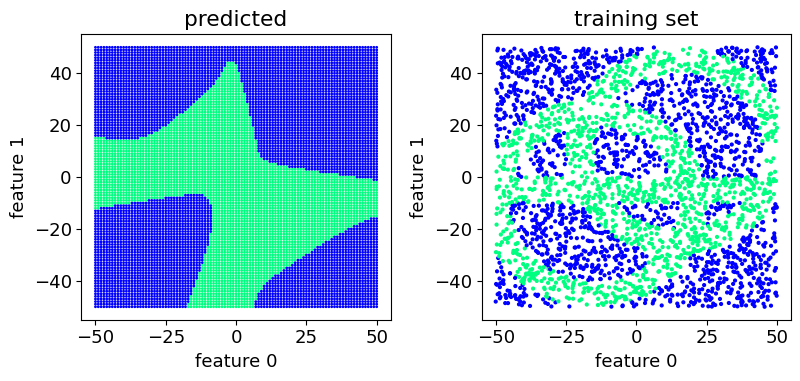

errors: 30.80%   Accuracy=0.692


0.692

In [55]:
classify_nn(nn_model)

### a) Train set - Test set

In [ ]:
xgb_accs=[]
nn_accs=[]
fs=np.linspace(0.1, 0.9, 10)
for f in fs:
    print(f'...................................Train set ratio: {f*100:.1f}%............................................')
    N,L = len(x), len(x[0])

    N_train = int(f*N)
    x_train,y_train = x[:N_train],y[:N_train]
    x_test,y_test = x[N_train:],y[N_train:]
    print('xgb_model')
    xgb_accs.append(classify(xgb_model, show_prediction_plot=False))
    print('nn_model')
    nn_accs.append(classify_nn(nn_model))

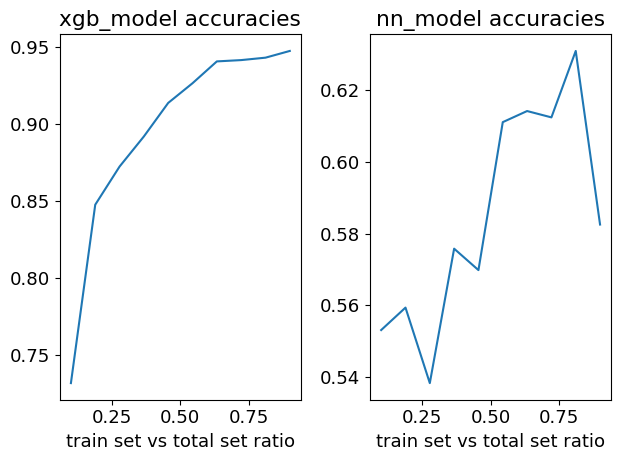

In [364]:
fig, (ax1, ax2)=plt.subplots(nrows=1, ncols=2)
ax1.plot(fs,xgb_accs)
ax1.set_title('xgb_model accuracies')
ax1.set_xlabel('train set vs total set ratio')
ax2.plot(fs, nn_accs)
ax2.set_title('nn_model accuracies')
ax2.set_xlabel('train set vs total set ratio')
fig.tight_layout()
plt.show()

We observe that the accuracy of the XGBoost model improves steadily, while the accuracy of the neural network oscillates heavily.

In [ ]:
xgb_accs=[]
nn_accs=[]
fs=np.linspace(0.001, 0.1, 100)
for f in fs:
    print(f'...................................Train set ratio: {f*100:.1f}%............................................')
    N,L = len(x), len(x[0])

    N_train = int(f*N)
    x_train,y_train = x[:N_train],y[:N_train]
    x_test,y_test = x[N_train:],y[N_train:]
    print('xgb_model')
    xgb_accs.append(classify(xgb_model, show_prediction_plot=False))
    print('nn_model')
    nn_accs.append(classify_nn(nn_model))

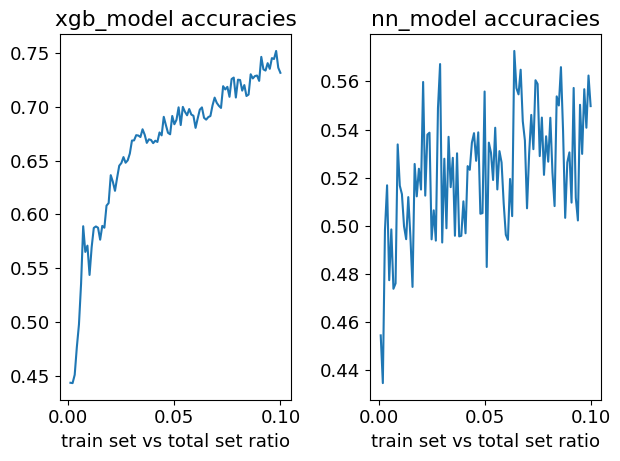

In [379]:
fig, (ax1, ax2)=plt.subplots(nrows=1, ncols=2)
ax1.plot(fs,xgb_accs)
ax1.set_title('xgb_model accuracies')
ax1.set_xlabel('train set vs total set ratio')
ax2.plot(fs, nn_accs)
ax2.set_title('nn_model accuracies')
ax2.set_xlabel('train set vs total set ratio')
fig.tight_layout()
plt.show()

Exploring the lower range of *N'* we observe that the progression of the accuracy for the XGBoost is much more stable than out simple NN model. We observe that the accuracy is higher for the `xgb_model` even for small size training set.

### b) Cross-validation

We now do the same vaying the number fo folds of the k-fold validation process.

In [ ]:
from sklearn.model_selection import cross_validate

xgb_accs=[]
nn_accs=[]
ks=range(2, 11, 1)
for k in ks:
    print(f'...................................Train set ratio (CV): {(k-1)/k*100:.1f}%............................................')
    print('xgb_model')
    scores=cross_validate(xgb_model, x,y,cv=k)
    print(scores['test_score'].mean())
    xgb_accs.append(scores['test_score'].mean())
    print('nn_model')
    scores=cross_validate(nn_model, x,y,cv=k)
    print(scores['test_score'].mean())
    nn_accs.append(scores['test_score'].mean())

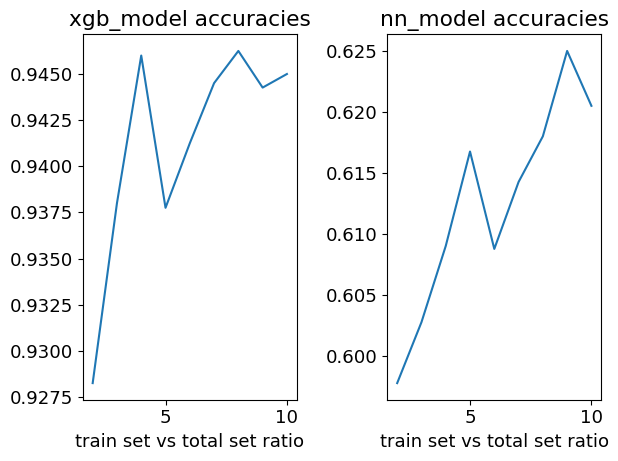

In [360]:
fig, (ax1, ax2)=plt.subplots(nrows=1, ncols=2)
ax1.plot(ks,xgb_accs)
ax1.set_title('xgb_model accuracies')
ax1.set_xlabel('train set vs total set ratio')
ax2.plot(ks, nn_accs)
ax2.set_title('nn_model accuracies')
ax2.set_xlabel('train set vs total set ratio')
fig.tight_layout()
plt.show()

The `xgb_model` shows as well in this case a steadily higher accuracy value w.r.t. the simple NN model.

## We re-do the analysis with the best model we found through the hyperparameters search

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD
from scikeras.wrappers import KerasClassifier
import time

#We implement a subclass just to make it work in the 3rd Section with the sklearn.cross_validate method
class KerasClassifierWithEvaluate(KerasClassifier):
    def score(self, *args, **kwargs):
        return self.evaluate(**args, **kwargs)

# Function to create model
def create_model(optimizer='adam', init='glorot_uniform', activation='relu', neurons=12, dropout_rate=0.0, learning_rate=0.01, momentum=0):
    if optimizer == 'sgd':
        optimizer = SGD(lr=learning_rate, momentum=momentum)
    model = Sequential()
    model.add(Dense(neurons, input_dim=x.shape[1], kernel_initializer=init, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, kernel_initializer=init, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


# Define the parameter grid
'''
param_grid = {
    'optimizer': ['rmsprop'],
    'init': ['glorot_uniform'],
    'activation': ['softmax'],
    'neurons': [8],
    'epochs': [2],
    'batch_size': [50],
    'dropout_rate': [0.0],
    'learning_rate': [0.1],
    'momentum': [0.0]
}

'''
param_grid = {
    'optimizer': ['rmsprop', 'adam', 'sgd'],
    'init': ['glorot_uniform', 'normal', 'uniform'],
    'activation': ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'],
    'neurons': [8, 12, 16, 20],
    'epochs': [50, 100, 150],
    'batch_size': [16, 32, 64],
    'dropout_rate': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'momentum': [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
}

# Function to perform grid search
def grid_search(X_train, y_train):
    model = KerasClassifier(build_fn=create_model, verbose=0, optimizer='adam', init='glorot_uniform', activation='relu', neurons=12, dropout_rate=0.0, learning_rate=0.01, momentum=0 )
    #model=create_model()
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=0)
    grid_result = grid.fit(X_train, y_train)
    # Summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    best_model = grid_result.best_estimator_
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    return best_model, means, stds, params


In [ ]:
estimator = KerasClassifier() 
print(estimator.get_params().keys())

In [ ]:
'''
import keras
nn_model=keras.models.load_model('/home/ema/Uni/LCPb/Exercises/Ex3/nn_model_1712046275.2711751')
best_accuracy = nn_model.evaluate(x_test, y_test)
print(nn_model.optimizer.get_config(), nn_model.get_config())
'''

In [ ]:
nn_model=best_nn_model
print(f'Best accuracy: {best_accuracy}\n best params: {best_params}')
model_path_and_name='./nn_model_'+str(time.time())
nn_model.model_.save(model_path_and_name)

Atfer different trials and ttempt we find the one below

In [95]:
best_params={'activation': ['softmax'], 'batch_size': [10], 'dropout_rate': [0.0], 'epochs': [100], 'init': ['normal'], 'learning_rate': [0.001], 'momentum': [0.0], 'neurons': [20], 'optimizer': ['rmsprop']}
param_grid=best_params
best_model, means, stds, params= grid_search(x_train,y_train)
nn_model=best_model
test_accuracy = nn_model.score(x_test, y_test)
print(test_accuracy)

2024-04-02 15:51:51.025305: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-02 15:51:51.025354: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-02 15:51:51.026873: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-02 15:51:51.036034: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-02 15:51:51.184750: E external/local_xla/xla/

Best: 0.558333 using {'activation': 'softmax', 'batch_size': 10, 'dropout_rate': 0.0, 'epochs': 100, 'init': 'normal', 'learning_rate': 0.001, 'momentum': 0.0, 'neurons': 20, 'optimizer': 'rmsprop'}
0.558333 (0.000471) with: {'activation': 'softmax', 'batch_size': 10, 'dropout_rate': 0.0, 'epochs': 100, 'init': 'normal', 'learning_rate': 0.001, 'momentum': 0.0, 'neurons': 20, 'optimizer': 'rmsprop'}
0.548


In [ ]:
import random
model_path_and_name='./nn_model_'+str(time.time())
montecarlo_duration=60*60*1
start=time.time()
best_accuracy=0
while time.time()-start<montecarlo_duration:
    parameters={}
    for param in param_grid.items():
        if isinstance(param[1][0], int):
            parameters[param[0]]=[random.randint(param[1][0], param[1][-1])]
        elif isinstance(param[1][0], float):
            parameters[param[0]]=[random.uniform(param[1][0], param[1][-1])]  
        elif isinstance(param[1][0], str):
            parameters[param[0]]=[random.choice(param[1])]
        else:
            print('something else')
    param_grid=parameters
    best_model, means, stds, params= grid_search(x,y)
    nn_model=best_model
    test_accuracy = nn_model.score(x_test, y_test)
    
    if test_accuracy>best_accuracy:
        best_accuracy=test_accuracy
        best_params=parameters
        best_nn_model=nn_model
        nn_model.model_.save(model_path_and_name)
nn_model=best_nn_model
                 

/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


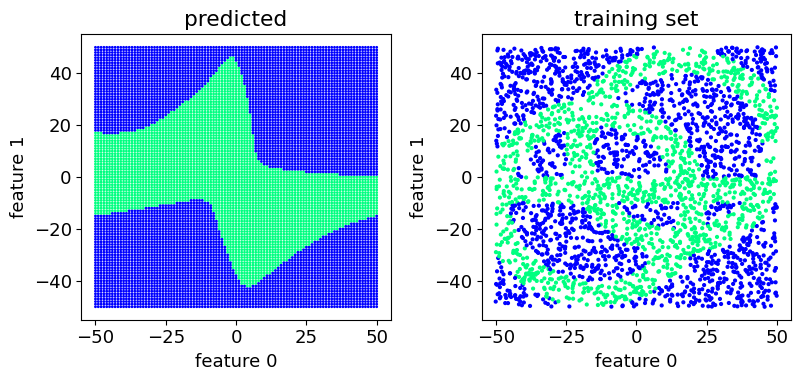

errors: 28.20%   Accuracy=0.718


0.718

In [57]:
classify_nn(nn_model)

### a) Train set - Test set

In [37]:
xgb_accs=[]
nn_accs=[]
fs=np.linspace(0.1, 0.9, 10)
for f in fs:
    print(f'...................................Train set ratio: {f*100:.1f}%............................................')
    N,L = len(x), len(x[0])

    N_train = int(f*N)
    x_train,y_train = x[:N_train],y[:N_train]
    x_test,y_test = x[N_train:],y[N_train:]
    print('xgb_model')
    xgb_accs.append(classify(xgb_model, show_prediction_plot=False))
    print('nn_model')
    nn_accs.append(classify_nn(nn_model))

...................................Train set ratio: 10.0%............................................
xgb_model
errors: 26.86%   Accuracy=0.731
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 43.22%   Accuracy=0.568
...................................Train set ratio: 18.9%............................................
xgb_model
errors: 15.25%   Accuracy=0.847
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 37.26%   Accuracy=0.627
...................................Train set ratio: 27.8%............................................
xgb_model
errors: 12.77%   Accuracy=0.872
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 37.18%   Accuracy=0.628
...................................Train set ratio: 36.7%............................................
xgb_model
errors: 10.81%   Accuracy=0.892
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 33.98%   Accuracy=0.660
...................................Train set ratio: 45.6%............................................
xgb_model
errors: 8.63%   Accuracy=0.914
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 32.37%   Accuracy=0.676
...................................Train set ratio: 54.4%............................................
xgb_model
errors: 7.35%   Accuracy=0.926
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 32.09%   Accuracy=0.679
...................................Train set ratio: 63.3%............................................
xgb_model
errors: 5.93%   Accuracy=0.941
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 30.33%   Accuracy=0.697
...................................Train set ratio: 72.2%............................................
xgb_model
errors: 5.85%   Accuracy=0.942
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 29.23%   Accuracy=0.708
...................................Train set ratio: 81.1%............................................
xgb_model
errors: 5.69%   Accuracy=0.943
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 28.70%   Accuracy=0.713
...................................Train set ratio: 90.0%............................................
xgb_model
errors: 5.25%   Accuracy=0.948
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 29.25%   Accuracy=0.708


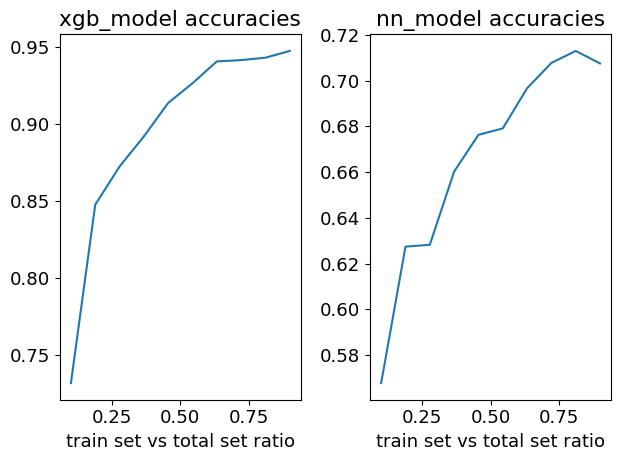

In [38]:
fig, (ax1, ax2)=plt.subplots(nrows=1, ncols=2)
ax1.plot(fs,xgb_accs)
ax1.set_title('xgb_model accuracies')
ax1.set_xlabel('train set vs total set ratio')
ax2.plot(fs, nn_accs)
ax2.set_title('nn_model accuracies')
ax2.set_xlabel('train set vs total set ratio')
fig.tight_layout()
plt.show()

We observe a similar shape in the XGBoost accuracy  and neural network accuracy vs training ratio, but the XGBoost model performs way better, with a >20% difference in accuracy. The main difference we observe is a decrease in the accuracy for very high values of training ratio for the neural network model. Compared to the non-optimized model, the trend of this NN is much more stable and less oscillating.

In [40]:
xgb_accs=[]
nn_accs=[]
fs=np.linspace(0.001, 0.1, 100)
for f in fs:
    print(f'...................................Train set ratio: {f*100:.1f}%............................................')
    N,L = len(x), len(x[0])

    N_train = int(f*N)
    x_train,y_train = x[:N_train],y[:N_train]
    x_test,y_test = x[N_train:],y[N_train:]
    print('xgb_model')
    xgb_accs.append(classify(xgb_model, show_prediction_plot=False))
    print('nn_model')
    nn_accs.append(classify_nn(nn_model))

...................................Train set ratio: 0.1%............................................
xgb_model
errors: 55.61%   Accuracy=0.444
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 53.43%   Accuracy=0.466
...................................Train set ratio: 0.2%............................................
xgb_model
errors: 55.64%   Accuracy=0.444
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 53.71%   Accuracy=0.463
...................................Train set ratio: 0.3%............................................
xgb_model
errors: 54.86%   Accuracy=0.451
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 50.75%   Accuracy=0.492
...................................Train set ratio: 0.4%............................................
xgb_model
errors: 52.31%   Accuracy=0.477
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 53.11%   Accuracy=0.469
...................................Train set ratio: 0.5%............................................
xgb_model
errors: 50.20%   Accuracy=0.498
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 54.35%   Accuracy=0.457
...................................Train set ratio: 0.6%............................................
xgb_model
errors: 46.43%   Accuracy=0.536
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 53.65%   Accuracy=0.464
...................................Train set ratio: 0.7%............................................
xgb_model
errors: 41.09%   Accuracy=0.589
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 52.82%   Accuracy=0.472
...................................Train set ratio: 0.8%............................................
xgb_model
errors: 43.47%   Accuracy=0.565
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 49.32%   Accuracy=0.507
...................................Train set ratio: 0.9%............................................
xgb_model
errors: 42.89%   Accuracy=0.571
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 49.65%   Accuracy=0.504
...................................Train set ratio: 1.0%............................................
xgb_model
errors: 45.61%   Accuracy=0.544
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 48.31%   Accuracy=0.517
...................................Train set ratio: 1.1%............................................
xgb_model
errors: 43.02%   Accuracy=0.570
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 48.00%   Accuracy=0.520
...................................Train set ratio: 1.2%............................................
xgb_model
errors: 41.24%   Accuracy=0.588
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 47.09%   Accuracy=0.529
...................................Train set ratio: 1.3%............................................
xgb_model
errors: 41.11%   Accuracy=0.589
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 48.61%   Accuracy=0.514
...................................Train set ratio: 1.4%............................................
xgb_model
errors: 41.23%   Accuracy=0.588
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 47.57%   Accuracy=0.524
...................................Train set ratio: 1.5%............................................
xgb_model
errors: 42.34%   Accuracy=0.577
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 48.71%   Accuracy=0.513
...................................Train set ratio: 1.6%............................................
xgb_model
errors: 41.06%   Accuracy=0.589
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 48.22%   Accuracy=0.518
...................................Train set ratio: 1.7%............................................
xgb_model
errors: 41.23%   Accuracy=0.588
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 47.56%   Accuracy=0.524
...................................Train set ratio: 1.8%............................................
xgb_model
errors: 39.18%   Accuracy=0.608
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 45.04%   Accuracy=0.550
...................................Train set ratio: 1.9%............................................
xgb_model
errors: 38.94%   Accuracy=0.611
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 46.53%   Accuracy=0.535
...................................Train set ratio: 2.0%............................................
xgb_model
errors: 36.35%   Accuracy=0.636
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 47.55%   Accuracy=0.524
...................................Train set ratio: 2.1%............................................
xgb_model
errors: 36.98%   Accuracy=0.630
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 44.51%   Accuracy=0.555
...................................Train set ratio: 2.2%............................................
xgb_model
errors: 37.81%   Accuracy=0.622
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 45.81%   Accuracy=0.542
...................................Train set ratio: 2.3%............................................
xgb_model
errors: 36.59%   Accuracy=0.634
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 47.52%   Accuracy=0.525
...................................Train set ratio: 2.4%............................................
xgb_model
errors: 35.48%   Accuracy=0.645
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 48.49%   Accuracy=0.515
...................................Train set ratio: 2.5%............................................
xgb_model
errors: 35.23%   Accuracy=0.648
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 47.00%   Accuracy=0.530
...................................Train set ratio: 2.6%............................................
xgb_model
errors: 34.68%   Accuracy=0.653
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 44.56%   Accuracy=0.554
...................................Train set ratio: 2.7%............................................
xgb_model
errors: 35.20%   Accuracy=0.648
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 44.04%   Accuracy=0.560
...................................Train set ratio: 2.8%............................................
xgb_model
errors: 34.98%   Accuracy=0.650
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 45.88%   Accuracy=0.541
...................................Train set ratio: 2.9%............................................
xgb_model
errors: 34.35%   Accuracy=0.657
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 42.74%   Accuracy=0.573
...................................Train set ratio: 3.0%............................................
xgb_model
errors: 33.14%   Accuracy=0.669
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 44.36%   Accuracy=0.556
...................................Train set ratio: 3.1%............................................
xgb_model
errors: 33.13%   Accuracy=0.669
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 43.86%   Accuracy=0.561
...................................Train set ratio: 3.2%............................................
xgb_model
errors: 32.64%   Accuracy=0.674
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 45.27%   Accuracy=0.547
...................................Train set ratio: 3.3%............................................
xgb_model
errors: 32.68%   Accuracy=0.673
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 43.20%   Accuracy=0.568
...................................Train set ratio: 3.4%............................................
xgb_model
errors: 32.82%   Accuracy=0.672
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 44.44%   Accuracy=0.556
...................................Train set ratio: 3.5%............................................
xgb_model
errors: 32.10%   Accuracy=0.679
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 41.17%   Accuracy=0.588
...................................Train set ratio: 3.6%............................................
xgb_model
errors: 32.60%   Accuracy=0.674
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 43.83%   Accuracy=0.562
...................................Train set ratio: 3.7%............................................
xgb_model
errors: 33.36%   Accuracy=0.666
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 43.67%   Accuracy=0.563
...................................Train set ratio: 3.8%............................................
xgb_model
errors: 33.03%   Accuracy=0.670
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 39.92%   Accuracy=0.601
...................................Train set ratio: 3.9%............................................
xgb_model
errors: 33.09%   Accuracy=0.669
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 41.60%   Accuracy=0.584
...................................Train set ratio: 4.0%............................................
xgb_model
errors: 33.39%   Accuracy=0.666
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 41.67%   Accuracy=0.583
...................................Train set ratio: 4.1%............................................
xgb_model
errors: 33.16%   Accuracy=0.668
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 41.79%   Accuracy=0.582
...................................Train set ratio: 4.2%............................................
xgb_model
errors: 33.27%   Accuracy=0.667
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 39.14%   Accuracy=0.609
...................................Train set ratio: 4.3%............................................
xgb_model
errors: 32.39%   Accuracy=0.676
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 40.88%   Accuracy=0.591
...................................Train set ratio: 4.4%............................................
xgb_model
errors: 32.66%   Accuracy=0.673
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 41.21%   Accuracy=0.588
...................................Train set ratio: 4.5%............................................
xgb_model
errors: 30.94%   Accuracy=0.691
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 39.37%   Accuracy=0.606
...................................Train set ratio: 4.6%............................................
xgb_model
errors: 31.71%   Accuracy=0.683
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 40.67%   Accuracy=0.593
...................................Train set ratio: 4.7%............................................
xgb_model
errors: 32.42%   Accuracy=0.676
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 40.32%   Accuracy=0.597
...................................Train set ratio: 4.8%............................................
xgb_model
errors: 32.56%   Accuracy=0.674
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 40.13%   Accuracy=0.599
...................................Train set ratio: 4.9%............................................
xgb_model
errors: 30.86%   Accuracy=0.691
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 41.40%   Accuracy=0.586
...................................Train set ratio: 5.0%............................................
xgb_model
errors: 31.63%   Accuracy=0.684
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 40.26%   Accuracy=0.597
...................................Train set ratio: 5.1%............................................
xgb_model
errors: 31.22%   Accuracy=0.688
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 41.07%   Accuracy=0.589
...................................Train set ratio: 5.2%............................................
xgb_model
errors: 30.06%   Accuracy=0.699
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 39.77%   Accuracy=0.602
...................................Train set ratio: 5.3%............................................
xgb_model
errors: 31.71%   Accuracy=0.683
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 40.50%   Accuracy=0.595
...................................Train set ratio: 5.4%............................................
xgb_model
errors: 30.02%   Accuracy=0.700
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 40.49%   Accuracy=0.595
...................................Train set ratio: 5.5%............................................
xgb_model
errors: 30.48%   Accuracy=0.695
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 40.34%   Accuracy=0.597
...................................Train set ratio: 5.6%............................................
xgb_model
errors: 30.80%   Accuracy=0.692
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 37.71%   Accuracy=0.623
...................................Train set ratio: 5.7%............................................
xgb_model
errors: 30.22%   Accuracy=0.698
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 39.66%   Accuracy=0.603
...................................Train set ratio: 5.8%............................................
xgb_model
errors: 30.73%   Accuracy=0.693
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 38.59%   Accuracy=0.614
...................................Train set ratio: 5.9%............................................
xgb_model
errors: 30.84%   Accuracy=0.692
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 38.74%   Accuracy=0.613
...................................Train set ratio: 6.0%............................................
xgb_model
errors: 31.97%   Accuracy=0.680
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 39.07%   Accuracy=0.609
...................................Train set ratio: 6.1%............................................
xgb_model
errors: 31.10%   Accuracy=0.689
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 41.08%   Accuracy=0.589
...................................Train set ratio: 6.2%............................................
xgb_model
errors: 30.28%   Accuracy=0.697
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 40.17%   Accuracy=0.598
...................................Train set ratio: 6.3%............................................
xgb_model
errors: 30.07%   Accuracy=0.699
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 40.21%   Accuracy=0.598
...................................Train set ratio: 6.4%............................................
xgb_model
errors: 31.04%   Accuracy=0.690
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 38.35%   Accuracy=0.616
...................................Train set ratio: 6.5%............................................
xgb_model
errors: 31.20%   Accuracy=0.688
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 40.56%   Accuracy=0.594
...................................Train set ratio: 6.6%............................................
xgb_model
errors: 30.97%   Accuracy=0.690
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 40.69%   Accuracy=0.593
...................................Train set ratio: 6.7%............................................
xgb_model
errors: 30.87%   Accuracy=0.691
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 40.09%   Accuracy=0.599
...................................Train set ratio: 6.8%............................................
xgb_model
errors: 29.88%   Accuracy=0.701
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 39.81%   Accuracy=0.602
...................................Train set ratio: 6.9%............................................
xgb_model
errors: 29.16%   Accuracy=0.708
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 38.72%   Accuracy=0.613
...................................Train set ratio: 7.0%............................................
xgb_model
errors: 29.65%   Accuracy=0.703
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 39.62%   Accuracy=0.604
...................................Train set ratio: 7.1%............................................
xgb_model
errors: 29.92%   Accuracy=0.701
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 40.15%   Accuracy=0.598
...................................Train set ratio: 7.2%............................................
xgb_model
errors: 30.12%   Accuracy=0.699
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 40.60%   Accuracy=0.594
...................................Train set ratio: 7.3%............................................
xgb_model
errors: 28.10%   Accuracy=0.719
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 41.26%   Accuracy=0.587
...................................Train set ratio: 7.4%............................................
xgb_model
errors: 28.40%   Accuracy=0.716
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 41.60%   Accuracy=0.584
...................................Train set ratio: 7.5%............................................
xgb_model
errors: 28.16%   Accuracy=0.718
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 40.86%   Accuracy=0.591
...................................Train set ratio: 7.6%............................................
xgb_model
errors: 29.09%   Accuracy=0.709
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 40.50%   Accuracy=0.595
...................................Train set ratio: 7.7%............................................
xgb_model
errors: 27.44%   Accuracy=0.726
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 40.82%   Accuracy=0.592
...................................Train set ratio: 7.8%............................................
xgb_model
errors: 27.30%   Accuracy=0.727
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 40.84%   Accuracy=0.592
...................................Train set ratio: 7.9%............................................
xgb_model
errors: 29.15%   Accuracy=0.708
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 40.23%   Accuracy=0.598
...................................Train set ratio: 8.0%............................................
xgb_model
errors: 27.50%   Accuracy=0.725
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 38.75%   Accuracy=0.613
...................................Train set ratio: 8.1%............................................
xgb_model
errors: 27.53%   Accuracy=0.725
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 40.56%   Accuracy=0.594
...................................Train set ratio: 8.2%............................................
xgb_model
errors: 28.51%   Accuracy=0.715
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 40.93%   Accuracy=0.591
...................................Train set ratio: 8.3%............................................
xgb_model
errors: 28.00%   Accuracy=0.720
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 38.93%   Accuracy=0.611
...................................Train set ratio: 8.4%............................................
xgb_model
errors: 29.01%   Accuracy=0.710
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 38.78%   Accuracy=0.612
...................................Train set ratio: 8.5%............................................
xgb_model
errors: 28.88%   Accuracy=0.711
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 42.27%   Accuracy=0.577
...................................Train set ratio: 8.6%............................................
xgb_model
errors: 27.00%   Accuracy=0.730
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 38.46%   Accuracy=0.615
...................................Train set ratio: 8.7%............................................
xgb_model
errors: 27.38%   Accuracy=0.726
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 38.42%   Accuracy=0.616
...................................Train set ratio: 8.8%............................................
xgb_model
errors: 27.17%   Accuracy=0.728
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 39.39%   Accuracy=0.606
...................................Train set ratio: 8.9%............................................
xgb_model
errors: 27.11%   Accuracy=0.729
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 40.07%   Accuracy=0.599
...................................Train set ratio: 9.0%............................................
xgb_model
errors: 27.61%   Accuracy=0.724
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 41.48%   Accuracy=0.585
...................................Train set ratio: 9.1%............................................
xgb_model
errors: 25.39%   Accuracy=0.746
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 40.98%   Accuracy=0.590
...................................Train set ratio: 9.2%............................................
xgb_model
errors: 26.54%   Accuracy=0.735
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 38.77%   Accuracy=0.612
...................................Train set ratio: 9.3%............................................
xgb_model
errors: 26.65%   Accuracy=0.733
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 41.07%   Accuracy=0.589
...................................Train set ratio: 9.4%............................................
xgb_model
errors: 25.97%   Accuracy=0.740
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 39.93%   Accuracy=0.601
...................................Train set ratio: 9.5%............................................
xgb_model
errors: 26.49%   Accuracy=0.735
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 39.36%   Accuracy=0.606
...................................Train set ratio: 9.6%............................................
xgb_model
errors: 25.50%   Accuracy=0.745
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 42.23%   Accuracy=0.578
...................................Train set ratio: 9.7%............................................
xgb_model
errors: 25.58%   Accuracy=0.744
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 40.06%   Accuracy=0.599
...................................Train set ratio: 9.8%............................................
xgb_model
errors: 24.83%   Accuracy=0.752
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 40.85%   Accuracy=0.591
...................................Train set ratio: 9.9%............................................
xgb_model
errors: 26.39%   Accuracy=0.736
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 41.98%   Accuracy=0.580
...................................Train set ratio: 10.0%............................................
xgb_model
errors: 26.86%   Accuracy=0.731
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


errors: 39.72%   Accuracy=0.603


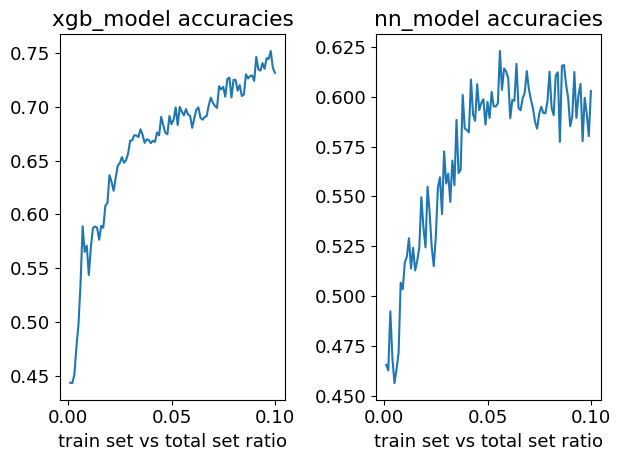

In [41]:
fig, (ax1, ax2)=plt.subplots(nrows=1, ncols=2)
ax1.plot(fs,xgb_accs)
ax1.set_title('xgb_model accuracies')
ax1.set_xlabel('train set vs total set ratio')
ax2.plot(fs, nn_accs)
ax2.set_title('nn_model accuracies')
ax2.set_xlabel('train set vs total set ratio')
fig.tight_layout()
plt.show()

Exploring the lower range of *N'* we observe that the progression of the accuracy for the XGBoost is much more stable than out simple NN model. We observe that the accuracy is higher for the `xgb_model` even for small size training set. The main difference in trend is in the steadily and quickly increasing accuracy of the XGBoost model w.r.t. the NN model.

### b) Cross-validation

We now do the same vaying the number fo folds of the k-fold validation process.

In [42]:
from sklearn.model_selection import cross_validate

xgb_accs=[]
nn_accs=[]
ks=range(2, 11, 1)
for k in ks:
    print(f'...................................Train set ratio (CV): {(k-1)/k*100:.1f}%............................................')
    print('xgb_model')
    scores=cross_validate(xgb_model, x,y,cv=k)
    print(scores['test_score'].mean())
    xgb_accs.append(scores['test_score'].mean())
    print('nn_model')
    scores=cross_validate(nn_model, x,y,cv=k)
    print(scores['test_score'].mean())
    nn_accs.append(scores['test_score'].mean())

...................................Train set ratio (CV): 50.0%............................................
xgb_model
0.92825
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


0.69325
...................................Train set ratio (CV): 66.7%............................................
xgb_model
0.9380032414400451
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


0.700998150587122
...................................Train set ratio (CV): 75.0%............................................
xgb_model
0.9460000000000001
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


0.711
...................................Train set ratio (CV): 80.0%............................................
xgb_model
0.93775
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ema/.local/lib/pyt

0.7114999999999999
...................................Train set ratio (CV): 83.3%............................................
xgb_model
0.9412470941706323
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ema/.local/lib/pyt

0.7154936045490768
...................................Train set ratio (CV): 85.7%............................................
xgb_model
0.9445055819836906
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ema/.local/lib/pyt

0.7100010322427135
...................................Train set ratio (CV): 87.5%............................................
xgb_model
0.94625
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ema/.local/lib/pyt

0.715
...................................Train set ratio (CV): 88.9%............................................
xgb_model
0.9442644892083094
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ema/.local/lib/pyt

0.7154975199919021
...................................Train set ratio (CV): 90.0%............................................
xgb_model
0.9450000000000001
nn_model


/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ema/.local/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ema/.local/lib/pyt

0.7155


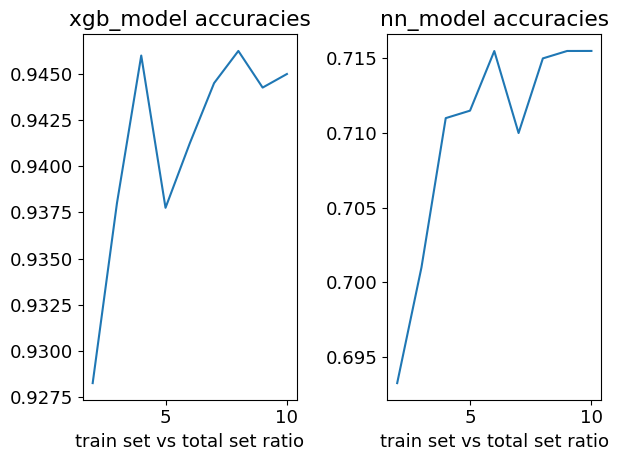

In [43]:
fig, (ax1, ax2)=plt.subplots(nrows=1, ncols=2)
ax1.plot(ks,xgb_accs)
ax1.set_title('xgb_model accuracies')
ax1.set_xlabel('train set vs total set ratio')
ax2.plot(ks, nn_accs)
ax2.set_title('nn_model accuracies')
ax2.set_xlabel('train set vs total set ratio')
fig.tight_layout()
plt.show()

The `xgb_model` shows as well in this case a steadily higher accuracy value w.r.t. the NN model.